In [2]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/topic-summary/topic_summary.csv
/kaggle/input/indonesia-gelap/indonesiagelap_tm_spelling fixed.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('/kaggle/input/indonesia-gelap/indonesiagelap_tm_spelling fixed.csv')
df.head()

id        date                                          full_text
0   0  14-02-2025  @AiraNtieReal @wa2nntx hmmmm ku sedih naikin h...
1   1  14-02-2025  Perlu berapa banyak warna lagi? #savekipkuliah...
2   2  14-02-2025  Segera membaik indonesia #IndonesiaGelap https...
3   3  14-02-2025  Dampak efisiensi APBN Karena banyak hutang yg ...
4   4  14-02-2025  Yang joget joget yang kalau dikasih tau kemari...

# Preprocessing

In [19]:
!pip install sastrawi nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.0 MB/s eta 0:00:00


In [20]:
import re
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
import nltk

# Download stopwords
nltk.download('stopwords')
stopwords_id = set(stopwords.words('indonesian'))

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Superscript unicode pattern
SUPERSCRIPT_PATTERN = r"[⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁽⁾ⁿ]"

# Kamus normalisasi kata informal → formal
alay_dict = {
    'ga': 'tidak',
    'gak': 'tidak',
    'nggak': 'tidak',
    'ngga': 'tidak',
    'gitu': 'begitu',
    'aja': 'saja',
    'yg': 'yang',
    'klo': 'kalau',
    'kalo': 'kalau',
    'dr': 'dari',
    'tp': 'tapi',
    'tdk': 'tidak',
    'blm': 'belum',
    'udh': 'sudah',
    'sdh': 'sudah',
    'sm': 'sama',
    'smua': 'semua',
    'dgn': 'dengan',
    'sy': 'saya',
    'gw': 'saya',
    'gue': 'saya',
    'lu': 'kamu',
    'lo': 'kamu'
    # tambahkan lebih banyak jika perlu
}

def normalize_alay(text):
    return " ".join([alay_dict.get(word, word) for word in text.split()])

def merge_particles(text):
    # Gabungkan partikel -nya, -ku, -mu yang terpisah
    text = re.sub(r'\b(\w+)\s+(nya|ku|mu)\b', r'\1\2', text)
    return text

def preprocess_tweet(text):
    if pd.isnull(text):
        return ""

    # Lowercase
    text = text.lower()

    # Hilangkan URL, mention, hashtag, superscript, simbol
    text = re.sub(r"http\S+|www\S+|pic.twitter.com\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(SUPERSCRIPT_PATTERN, "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # Normalisasi kata informal
    text = normalize_alay(text)

    # Gabungkan partikel yang terpisah
    text = merge_particles(text)

    # Stemming
    text = stemmer.stem(text)

    # Stopword removal
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords_id]

    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def preprocess_tweet_without_stem_stopword(text):
    if pd.isnull(text):
        return ""

    # Lowercase
    text = text.lower()

    # Hapus URL, mention, hashtag, superscript, simbol
    text = re.sub(r"http\S+|www\S+|pic.twitter.com\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(SUPERSCRIPT_PATTERN, "", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # Normalisasi kata informal
    text = normalize_alay(text)

    # Gabungkan partikel -nya, -ku, -mu
    text = merge_particles(text)

    return text

In [22]:
df_prepro = df.copy()

In [8]:
df_prepro['clean_text'] = df_prepro['full_text'].apply(preprocess_tweet)

In [23]:
df_prepro['clean_text_no_stem_stopword'] = df_prepro['full_text'].apply(preprocess_tweet_without_stem_stopword)

In [24]:
df_prepro.head()

id        date                                          full_text  \
0   0  14-02-2025  @AiraNtieReal @wa2nntx hmmmm ku sedih naikin h...   
1   1  14-02-2025  Perlu berapa banyak warna lagi? #savekipkuliah...   
2   2  14-02-2025  Segera membaik indonesia #IndonesiaGelap https...   
3   3  14-02-2025  Dampak efisiensi APBN Karena banyak hutang yg ...   
4   4  14-02-2025  Yang joget joget yang kalau dikasih tau kemari...   

                         clean_text_no_stem_stopword  
0  hmmmmku sedih naikin hastag saja lah kibarkan ...  
1                     perlu berapa banyak warna lagi  
2                           segera membaik indonesia  
3  dampak efisiensi apbn karena banyak hutang yan...  
4  yang joget joget yang kalau dikasih tau kemari...

# EDA

Pake yang cleaning dengan stopword dan stem

## Panjang Tweet

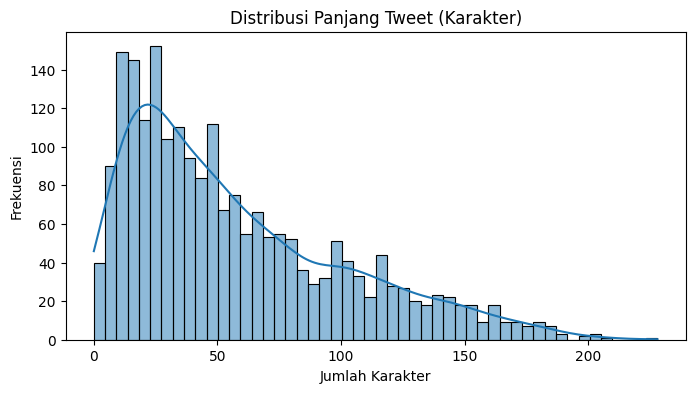

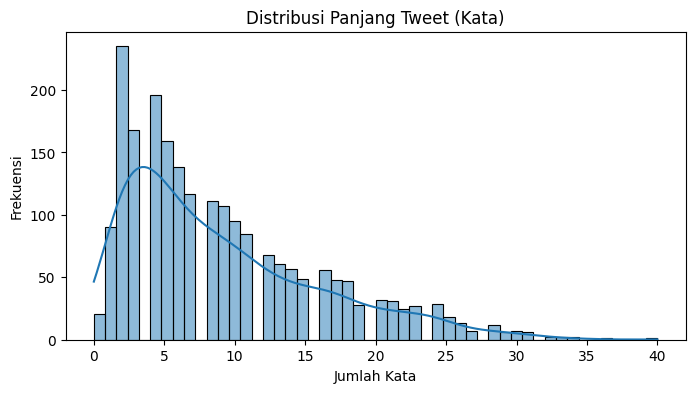

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Panjang karakter dan kata
df_prepro['char_len'] = df_prepro['clean_text'].str.len()
df_prepro['word_count'] = df_prepro['clean_text'].str.split().apply(len)

# Histogram panjang karakter
plt.figure(figsize=(8,4))
sns.histplot(df_prepro['char_len'], bins=50, kde=True)
plt.title("Distribusi Panjang Tweet (Karakter)")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Frekuensi")
plt.show()

# Histogram jumlah kata
plt.figure(figsize=(8,4))
sns.histplot(df_prepro['word_count'], bins=50, kde=True)
plt.title("Distribusi Panjang Tweet (Kata)")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.show()

## Wordcloud

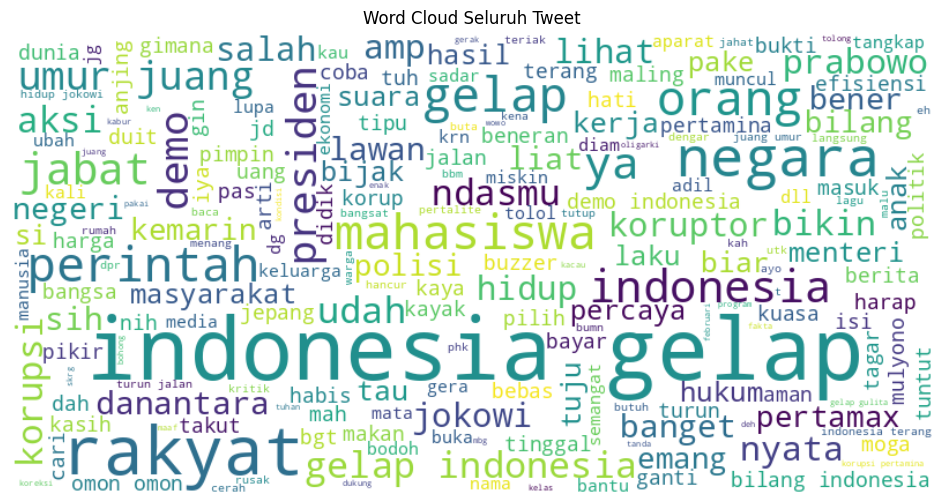

In [12]:
from wordcloud import WordCloud

# Gabungkan semua teks
all_text = " ".join(df_prepro['clean_text'])

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud Seluruh Tweet")
plt.show()

## Top 20 Kata

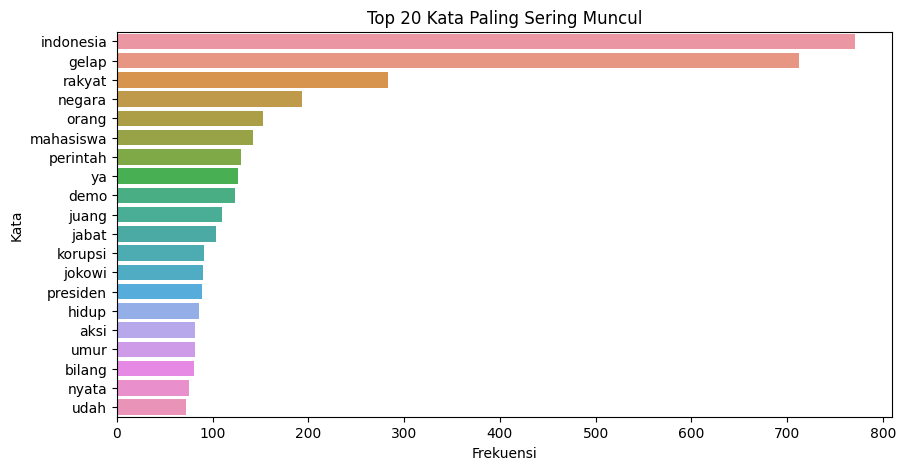

In [13]:
from collections import Counter

# Tokenisasi semua kata
all_words = " ".join(df_prepro['clean_text']).split()
word_freq = Counter(all_words).most_common(20)

# Barplot
words, counts = zip(*word_freq)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 20 Kata Paling Sering Muncul")
plt.xlabel("Frekuensi")
plt.ylabel("Kata")
plt.show()

## Visualisasi Bigram Teratas

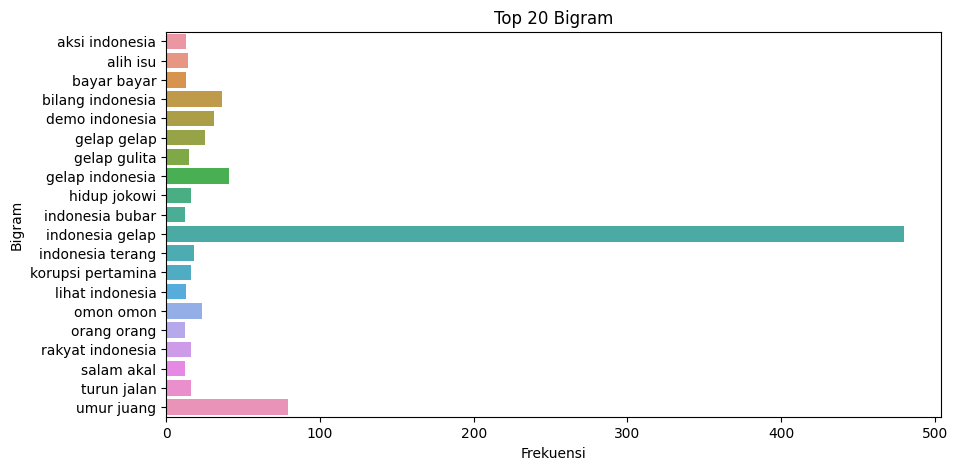

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorizer bigram
vectorizer = CountVectorizer(ngram_range=(2,2), max_features=20)
X_bigram = vectorizer.fit_transform(df_prepro['clean_text'])

# Ambil nama dan jumlah kemunculan bigram
bigrams = vectorizer.get_feature_names_out()
bigram_counts = X_bigram.toarray().sum(axis=0)

# Barplot bigram
plt.figure(figsize=(10,5))
sns.barplot(x=bigram_counts, y=bigrams)
plt.title("Top 20 Bigram")
plt.xlabel("Frekuensi")
plt.ylabel("Bigram")
plt.show()

## Heatmap Word Co-occurrence

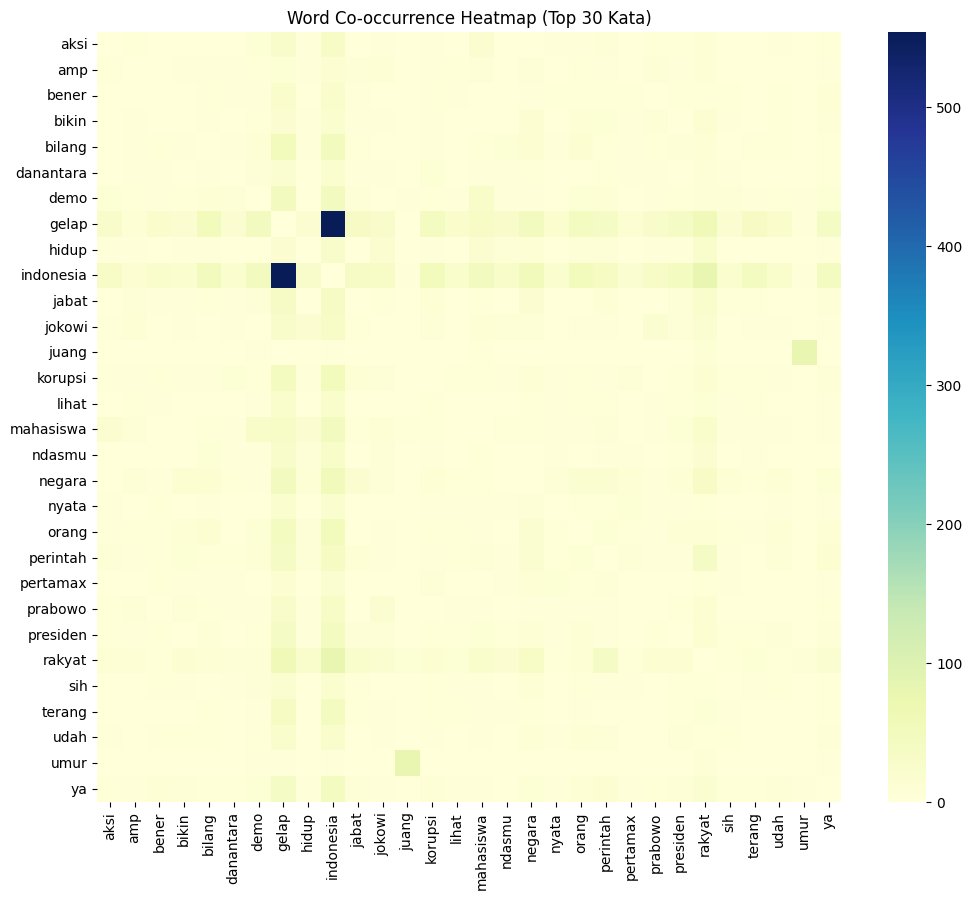

In [15]:
# Gunakan count vectorizer untuk top 30 kata
vectorizer = CountVectorizer(max_features=30, binary=True)
X_matrix = vectorizer.fit_transform(df_prepro['clean_text'])

# Hitung matrix co-occurrence
Xc = (X_matrix.T @ X_matrix)
Xc.setdiag(0)  # nolkan diagonal

# Ambil nama-nama kata
co_words = vectorizer.get_feature_names_out()
co_matrix = Xc.toarray()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(co_matrix, xticklabels=co_words, yticklabels=co_words, cmap="YlGnBu")
plt.title("Word Co-occurrence Heatmap (Top 30 Kata)")
plt.show()

# Topic Modeling

## BertTopic + MiniLM

In [11]:
!pip install bertopic sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 59.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitl

In [25]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

tweets = df_prepro['clean_text_no_stem_stopword'].tolist()

embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
topic_model = BERTopic(embedding_model=embedding_model, language="indonesian")
topics, probs = topic_model.fit_transform(tweets)

topic_model.get_topic_info()

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Topic  Count                                      Name  \
0      -1    953                     -1_yang_tidak_dan_ini   
1       0    122           0_gelap_indonesia_terang_gulita   
2       1    102            1_rakyat_koruptor_korupsi_yang   
3       2     68                    2_kau_aki_berarti_kata   
4       3     67           3_umur_panjang_perjuangan_kakak   
5       4     52           4_korupsi_rp_indonesia_koruptor   
6       5     46          5_mahasiswa_indonesia_demo_hidup   
7       6     40           6_pemerintah_kalian_negara_kami   
8       7     40          7_media_akunnya_report_dibungkam   
9       8     39           8_presiden_indonesia_gelap_elit   
10      9     39             9_gelap_habis_terbitlah_makin   
11     10     34                10_ndasmu_nder_lap_maraban   
12     11     33                   11_prab_jaman_sistem_dh   
13     12     32             12_mahasiswa_hidup_ukt_tinggi   
14     13     27        13_indonesia_cemas_masihkah_menuju   
15     14     27       14_pemerintah_indonesia_negara_kita   
16     15     27              15_indonesia_gelap_rp_pusing   
17     16     27             16_mantap_naikkan_bantu_tetap   
18     17     26           17_tagar_viral_muncul_postingan   
19     18     26        18_cacat_demokrasi_kebijakan_pikir   
20     19     26             19_negara_negeri_udah_sendiri   
21     20     24            20_terimakasih_keren_pagi_anak   
22     21     24              21_bayar_murah_dibayar_situs   
23     22     23             22_gelap_indonesia_grafik_boc   
24     23     22                 23_polisi_masuk_mul_teman   
25     24     21           24_pendidikan_gratis_dana_makan   
26     25     21                   25_pks_ya_hari_ternyata   
27     26     20                26_mahasiswa_kami_demo_amp   
28     27     18           27_presiden_ha_omon_presidennya   
29     28     18        28_makin_indonesia_gelap_mengalami   
30     29     15              29_gelap_indonesia_khan_nepo   
31     30     14                30_lawan_dapet_bangkit_api   
32     31     13                    31_jepang_vs_jiwa_juta   
33     32     13                 32_style_anime_chibi_ocku   
34     33     13     33_mereka_vertikal_diharap_horizontal   
35     34     13               34_sehat_keren_banget_biasa   
36     35     11               35_nye_jalan_turun_bersabar   
37     36     11                  36_makan_suwek_gt_apakah   
38     37     10  37_menteri_daripada_reshuffle_gemblengan   

                                       Representation  \
0   [yang, tidak, dan, ini, indonesia, ada, gelap,...   
1   [gelap, indonesia, terang, gulita, di, yang, j...   
2   [rakyat, koruptor, korupsi, yang, mereka, bank...   
3   [kau, aki, berarti, kata, tidak, malu, tak, or...   
4   [umur, panjang, perjuangan, kakak, sia, allahu...   
5   [korupsi, rp, indonesia, koruptor, pertamina, ...   
6   [mahasiswa, indonesia, demo, hidup, gelap, dan...   
7   [pemerintah, kalian, negara, kami, ini, lubang...   
8   [media, akunnya, report, dibungkam, tv, massa,...   
9   [presiden, indonesia, gelap, elit, bpk, amp, m...   
10  [gelap, habis, terbitlah, makin, lilin, hujan,...   
11  [ndasmu, nder, lap, maraban, yuks, kabupaten, ...   
12  [prab, jaman, sistem, dh, yai, astaghfirullah,...   
13  [mahasiswa, hidup, ukt, tinggi, gabung, briefi...   
14  [indonesia, cemas, masihkah, menuju, generasi,...   
15  [pemerintah, indonesia, negara, kita, tidak, m...   
16  [indonesia, gelap, rp, pusing, saja, makasar, ...   
17  [mantap, naikkan, bantu, tetap, angkat, mbah, ...   
18  [tagar, viral, muncul, postingan, viralkan, re...   
19  [cacat, demokrasi, kebijakan, pikir, pemilu, r...   
20  [negara, negeri, udah, sendiri, saya, kamu, ge...   
21  [terimakasih, keren, pagi, anak, kakak, abang,...   
22  [bayar, murah, dibayar, situs, cie, harga, cek...   
23  [gelap, indonesia, grafik, boc, ihsg, merah, ,...   
24  [polisi, masuk, mul, teman, kejaksaan, bandit,...   
25  [pendidikan, gratis, dana, makan, ang

In [34]:
probs[2]

0.7362577388579105

In [35]:
topics[2]

13

In [36]:
df_prepro['topic'] = topics
df_prepro['topic_confidence'] = probs

df_topic_detail = df_prepro[['clean_text_no_stem_stopword', 'topic', 'topic_confidence']]
df_topic_detail = df_topic_detail.merge(topic_info_df, how='left', left_on='topic', right_on='Topic')

In [37]:
df_topic_detail

clean_text_no_stem_stopword  topic  \
0     hmmmmku sedih naikin hastag saja lah kibarkan ...     -1   
1                        perlu berapa banyak warna lagi      9   
2                              segera membaik indonesia     13   
3     dampak efisiensi apbn karena banyak hutang yan...      1   
4     yang joget joget yang kalau dikasih tau kemari...      2   
...                                                 ...    ...   
2152  ini mah bukan indonesia gelap tapi indonesia b...     -1   
2153                salah satu indikasi indonesia gelap     -1   
2154  di indonesia kamu yang gelap buzzer sibuk jila...     -1   
2155  kok indonesia gelap sih bukannya semakin teran...      0   
2156                             grafik indonesia gelap     22   

      topic_confidence  Topic  Count                                Name  \
0             0.000000     -1    953               -1_yang_tidak_dan_ini   
1             0.192613      9     39       9_gelap_habis_terbitlah_makin   
2             0.736258     13     27  13_indonesia_cemas_masihkah_menuju   
3             0.757610      1    102      1_rakyat_koruptor_korupsi_yang   
4             1.000000      2     68              2_kau_aki_berarti_kata   
...                ...    ...    ...                                 ...   
2152          0.000000     -1    953               -1_yang_tidak_dan_ini   
2153          0.000000     -1    953               -1_yang_tidak_dan_ini   
2154          0.000000     -1    953               -1_yang_tidak_dan_ini   
2155          1.000000      0    122     0_gelap_indonesia_terang_gulita   
2156          0.020167     22     23       22_gelap_indonesia_grafik_boc   

                                         Representation  \
0     [yang, tidak, dan, ini, indonesia, ada, gelap,...   
1     [gelap, habis, terbitlah, makin, lilin, hujan,...   
2     [indonesia, cemas, masihkah, menuju, generasi,...   
3     [rakyat, koruptor, korupsi, yang, mereka, bank...   
4     [kau, aki, berarti, kata, tidak, malu, tak, or...   
...                                                 ...   
2152  [yang, tidak, dan, ini, indonesia, ada, gelap,...   
2153  [yang, tidak, dan, ini, indonesia, ada, gelap,...   
2154  [yang, tidak, dan, ini, indonesia, ada, gelap,...   
2155  [gelap, indonesia, terang, gulita, di, yang, j...   
2156  [gelap, indonesia, grafik, boc, ihsg, merah, ,...   

                                    Representative_Docs  
0     [kemarin dia bilang indonesia tidak gelap seka...  
1     [habis gelap terbitlah koma habis koma endingn...  
2     [indonesia berhasil mendapatkan kemerdekaannya...  
3     [bakar pake pertalite denda x kerugian sita as...  
4     [emang tidak bisa dipercaya kata kata ini aki ...  
...                                                 ...  
2152  [kemarin dia bilang indonesia tidak gelap seka...  
2153  [kemarin dia bilang indonesia tidak gelap seka...  
2154  [kemarin dia bilang indonesia tidak gelap seka...  
2155  [indonesia gelap gulita, gelap gulita indonesi...  
2156  [indonesia gelap, indonesia gelap, indonesia g...  

[2157 rows x 8 columns]

In [26]:
topic_info_df = topic_model.get_topic_info()
topic_info_df.to_csv("topic_summary.csv", index=False)

In [27]:
tm = pd.read_csv('/kaggle/input/topic-summary/topic_summary.csv')
tm

Topic  Count                                Name  \
0      -1    545               -1_yang_dan_tidak_ini   
1       0    450              0_ini_ya_saja_pertamax   
2       1    237        1_indonesia_gelap_tidak_yang   
3       2    167       2_gelap_indonesia_terang_yang   
4       3    108      3_rakyat_korupsi_koruptor_yang   
5       4     66     4_umur_panjang_perjuangan_kakak   
6       5     47     5_mahasiswa_indonesia_demo_yang   
7       6     46   6_kebijakan_pemilu_yang_demokrasi   
8       7     40       7_gelap_habis_terbitlah_makin   
9       8     40       8_negara_pemerintah_ini_tidak   
10      9     40    9_media_report_akunnya_dibungkam   
11     10     35      10_indonesia_gelap_maning_saja   
12     11     30       11_mahasiswa_hidup_ukt_tinggi   
13     12     28          12_polisi_hitam_teman_tahu   
14     13     25         13_viral_tagar_menit_muncul   
15     14     25  14_indonesia_cemas_menuju_masihkah   
16     15     24       15_negara_negeri_udah_sendiri   
17     16     23                16_prab_jaman_dh_yai   
18     17     23       17_gelap_indonesia_grafik_boc   
19     18     23     18_mahasiswa_demo_kami_presiden   
20     19     22     19_pendidikan_gratis_dana_makan   
21     20     21          20_bayar_dibayar_cie_situs   
22     21     19           21_mereka_enak_lebih_yang   
23     22     18     22_presiden_ha_omon_presidennya   
24     23     17  23_makin_gelap_indonesia_mengalami   
25     24     15      24_lawan_melawan_dapet_bangkit   
26     25     12              25_jepang_vs_jiwa_juta   
27     26     11           26_style_anime_chibi_ocku   

                                       Representation  \
0   ['yang', 'dan', 'tidak', 'ini', 'ada', 'rakyat...   
1   ['ini', 'ya', 'saja', 'pertamax', 'yang', 'har...   
2   ['indonesia', 'gelap', 'tidak', 'yang', 'korup...   
3   ['gelap', 'indonesia', 'terang', 'yang', 'guli...   
4   ['rakyat', 'korupsi', 'koruptor', 'yang', 'mer...   
5   ['umur', 'panjang', 'perjuangan', 'kakak', 'si...   
6   ['mahasiswa', 'indonesia', 'demo', 'yang', 'ge...   
7   ['kebijakan', 'pemilu', 'yang', 'demokrasi', '...   
8   ['gelap', 'habis', 'terbitlah', 'makin', 'lili...   
9   ['negara', 'pemerintah', 'ini', 'tidak', 'kali...   
10  ['media', 'report', 'akunnya', 'dibungkam', 't...   
11  ['indonesia', 'gelap', 'maning', 'saja', 'rp',...   
12  ['mahasiswa', 'hidup', 'ukt', 'tinggi', 'ptkin...   
13  ['polisi', 'hitam', 'teman', 'tahu', 'masuk', ...   
14  ['viral', 'tagar', 'menit', 'muncul', 'viralka...   
15  ['indonesia', 'cemas', 'menuju', 'masihkah', '...   
16  ['negara', 'negeri', 'udah', 'sendiri', 'kamu'...   
17  ['prab', 'jaman', 'dh', 'yai', 'bayar', 'indon...   
18  ['gelap', 'indonesia', 'grafik', 'boc', 'ihsg'...   
19  ['mahasiswa', 'demo', 'kami', 'presiden', 'rak...   
20  ['pendidikan', 'gratis', 'dana', 'makan', 'ang...   
21  ['bayar', 'dibayar', 'cie', 'situs', 'harga', ...   
22  ['mereka', 'enak', 'lebih', 'yang', 'rekan', '...   
23  ['presiden', 'ha', 'omon', 'presidennya', 'hor...   
24  ['makin', 'gelap', 'indonesia', 'mengalami', '...   
25  ['lawan', 'melawan', 'dapet', 'bangkit', 'api'...   
26  ['jepang', 'vs', 'jiwa', 'juta', 'bahasa', 'de...   
27  ['style', 'anime', 'chibi', 'ocku', 'aku', 'ma...   

                                  Representative_Docs  
0   ['kami gerombolan burung salwa sebagai rakyat ...  
1   ['kalau masih ada rasa penyesalan berarti masi...  
2   ['orang yang bilang indonesia gelap dan mau ka...  
3   ['gelap gulita indonesia', 'tapi kata pak prab...  
4   ['jadi selama ini ada pembatasan pertalite mes...  
5   ['panjang umur perjuangan', 'panjang umur perj...  
6   ['tuntutan mahasiswa dan rakyat yang turun ke ...  
7   ['aksi massa yang terjadi dalam beberapa di ha...  
8   ['gelap', 'habis gelap terbitlah perlawanan', ...  
9   ['fondasi negara ini sudah hancur lebur karena...  
10  ['report akunnya semua yang baca ini report ak...  
11  ['iya bang haha gua bangga menjadi anak sastra...

In [28]:
topic_map = {
    -1: "Noise",
    0: "Kekecewaan terhadap Moral Publik dan Elite",
    1: "Counter-Narasi terhadap Seruan 'Indonesia Gelap",
    2: "Penolakan terhadap Label 'Indonesia Gelap",
    3: "Kemarahan terhadap Korupsi dan Ketimpangan Hukum",
    4: "Seruan Solidaritas: Panjang Umur Perjuangan",
    5: "Aksi Demonstrasi Mahasiswa dan Tuntutan Rakyat",
    6: "Kritik terhadap Demokrasi Palsu dan Ketimpangan Sistemik",
    7: "Noise",
    8: "Krisis Kepercayaan Total terhadap Negara dan Sistem",
    9: "Ajakan Mass Report terhadap Media Massa yang Dianggap Menyesatkan",
    10: "Pengalaman Personal dan Kritik Sosial ala Generasi Muda",
    11: "Yel-Yel Aksi: Hidup Mahasiswa!",
    12: "Ketidakpercayaan terhadap Polisi dan Jaksa",
    13: "Noise",
    14: "Dari Indonesia Emas ke Indonesia Cemas",
    15: "Kejenuhan Sosial dan Emosi Mentah terhadap Negeri",
    16: "Kehancuran Multilevel: Dari BUMN hingga Moralitas",
    17: "Tagar Indonesia Gelap",
    18: "Pembelaan atas Hak Rakyat untuk Bersuara",
    19: "Kritik terhadap Pemangkasan Pendidikan dan Riset",
    20: "Kritik terhadap Aparat melalui Lagu 'Bayar Bayar Bayar",
    21: "Kekecewaan terhadap Apatisme dan Ajakan untuk Peduli",
    22: "Kritik terhadap Prabowo dan Kolusi Elit Politik",
    23: "Persepsi Memburuk terhadap Arah Bangsa",
    24: "Apresiasi Puitis terhadap Semangat Pejuang",
    25: "Perbandingan Keadaan Indonesia vs Jepang",
    26: "Noise"   
}


tm["Custom_Label"] = tm["Topic"].map(topic_map)



In [29]:
tm.to_csv("topic_summary_labeled.csv", index=False)

In [30]:
tm.head()

Topic  Count                            Name  \
0     -1    545           -1_yang_dan_tidak_ini   
1      0    450          0_ini_ya_saja_pertamax   
2      1    237    1_indonesia_gelap_tidak_yang   
3      2    167   2_gelap_indonesia_terang_yang   
4      3    108  3_rakyat_korupsi_koruptor_yang   

                                      Representation  \
0  ['yang', 'dan', 'tidak', 'ini', 'ada', 'rakyat...   
1  ['ini', 'ya', 'saja', 'pertamax', 'yang', 'har...   
2  ['indonesia', 'gelap', 'tidak', 'yang', 'korup...   
3  ['gelap', 'indonesia', 'terang', 'yang', 'guli...   
4  ['rakyat', 'korupsi', 'koruptor', 'yang', 'mer...   

                                 Representative_Docs  \
0  ['kami gerombolan burung salwa sebagai rakyat ...   
1  ['kalau masih ada rasa penyesalan berarti masi...   
2  ['orang yang bilang indonesia gelap dan mau ka...   
3  ['gelap gulita indonesia', 'tapi kata pak prab...   
4  ['jadi selama ini ada pembatasan pertalite mes...   

                                       Custom_Label  
0                                             Noise  
1        Kekecewaan terhadap Moral Publik dan Elite  
2   Counter-Narasi terhadap Seruan 'Indonesia Gelap  
3         Penolakan terhadap Label 'Indonesia Gelap  
4  Kemarahan terhadap Korupsi dan Ketimpangan Hukum

## Nilai Coherence Score

In [26]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

# --- Step 1: Ambil Topik yang BUKAN 'Noise' ---
valid_topics = tm[tm['Custom_Label'] != "Noise"]['Topic'].tolist()

# --- Step 2: Ambil daftar kata per topik dari BERTopic ---
topic_words_list = [
    [word for word, _ in topic_model.get_topics()[topic][:10]]
    for topic in valid_topics
]

# --- Step 3: Tokenisasi tweet (hasil preprocessing) ---
tokenized_docs = [doc.split() for doc in df_prepro['clean_text']]

# --- Step 4: Siapkan Dictionary dan Corpus untuk Gensim ---
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# --- Step 5: Hitung Coherence Score ---
coherence_model = CoherenceModel(
    topics=topic_words_list,
    texts=tokenized_docs,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print("Coherence Score (tanpa topik 'Noise'):", coherence_score)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Coherence Score (tanpa topik 'Noise'): 0.4651108354005394


>0.4 untuk data tweet sudah baik

## Visualisasi Topik

In [31]:
fig = topic_model.visualize_topics()
fig.show()

Topic 0 merupakan pusat narasi "Indonesia Gelap" yang paling dominan, dikelilingi oleh topik-topik berdekatan, yaitu topik 4, 9, 11, 12, 21, 24 yang bersama-sama mencerminkan kemarahan kolektif dan kesadaran sosial masyarakat.

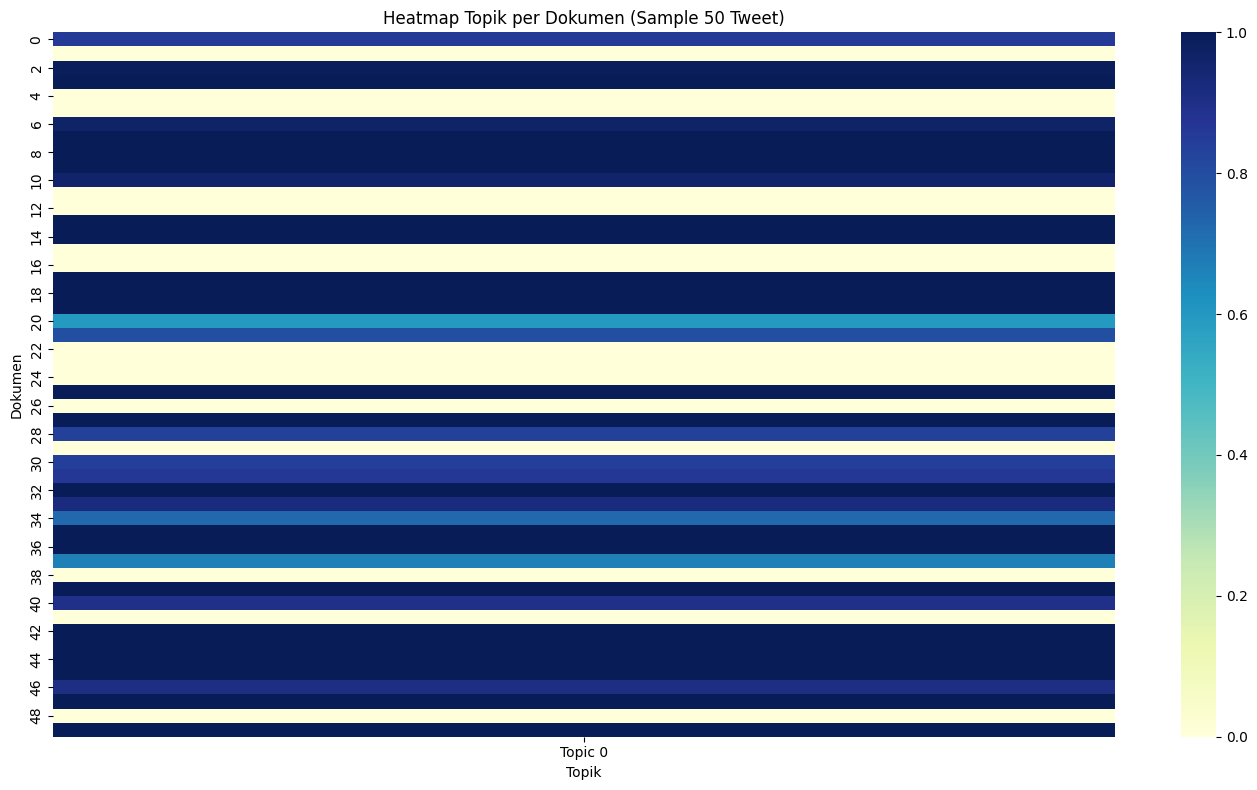

In [34]:
# Buat DataFrame dari probs
df_probs = pd.DataFrame(probs)
df_probs.columns = [f"Topic {i}" for i in range(df_probs.shape[1])]
df_probs["Dominant_Topic"] = topics

# (Optional) Filter sebagian dokumen saja untuk visualisasi
df_sample = df_probs.sample(50, random_state=42).reset_index(drop=True)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(df_sample.drop("Dominant_Topic", axis=1), cmap="YlGnBu")
plt.title("Heatmap Topik per Dokumen (Sample 50 Tweet)")
plt.xlabel("Topik")
plt.ylabel("Dokumen")
plt.tight_layout()
plt.show()


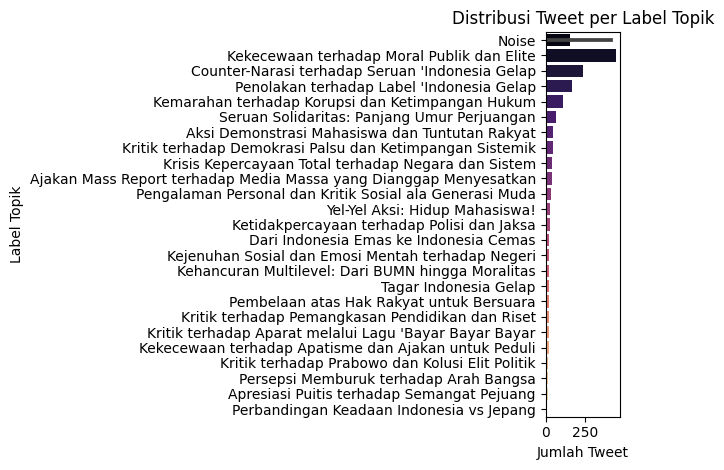

In [35]:
sns.barplot(data=tm.sort_values("Count", ascending=False), 
            x="Count", y="Custom_Label", palette="magma")
plt.title("Distribusi Tweet per Label Topik")
plt.xlabel("Jumlah Tweet")
plt.ylabel("Label Topik")
plt.tight_layout()
plt.show()

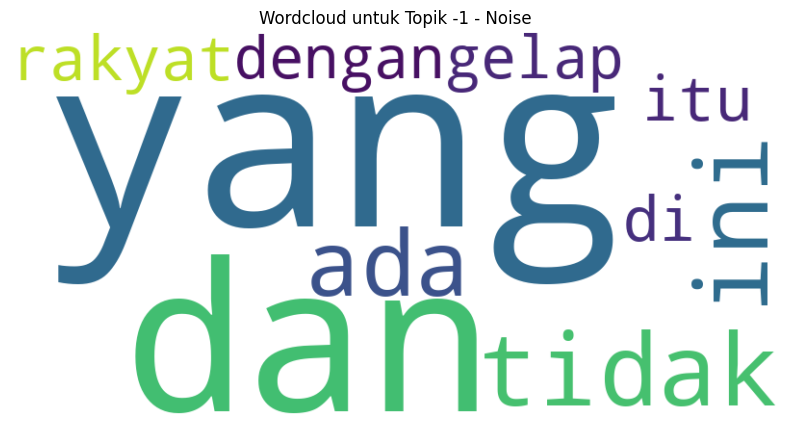

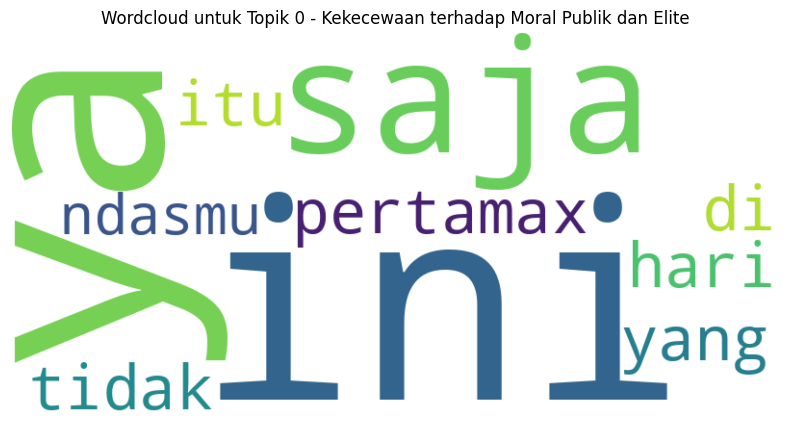

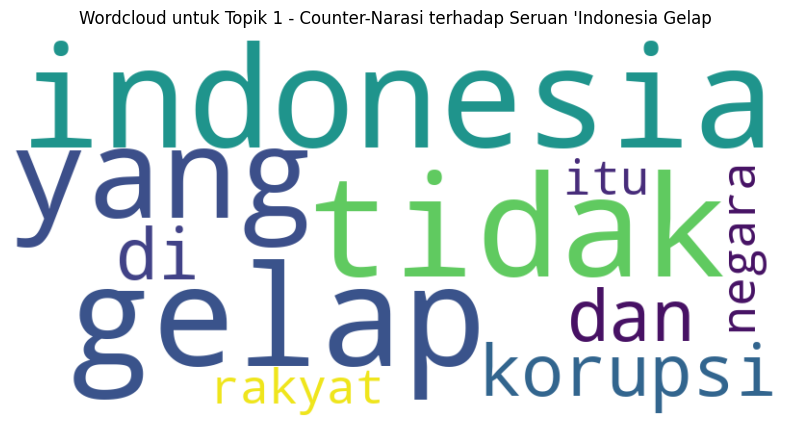

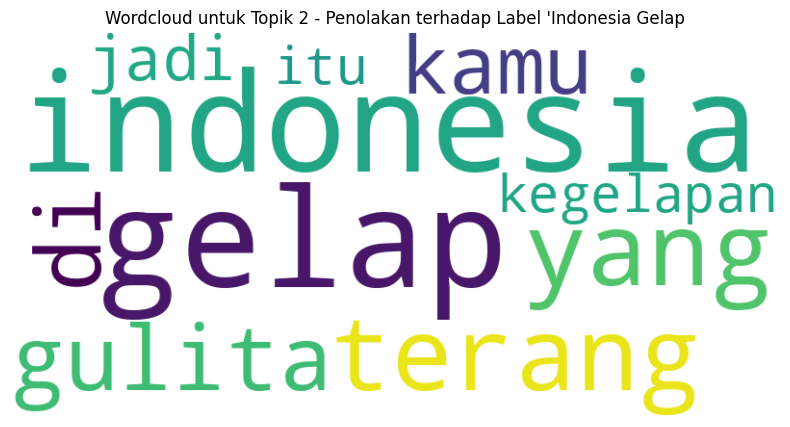

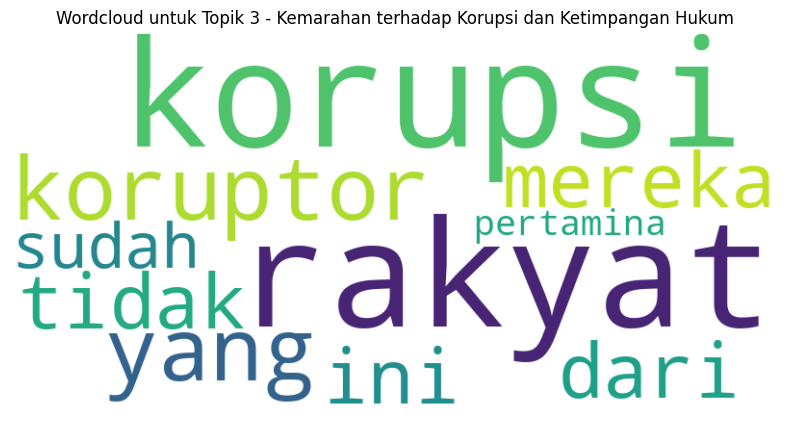

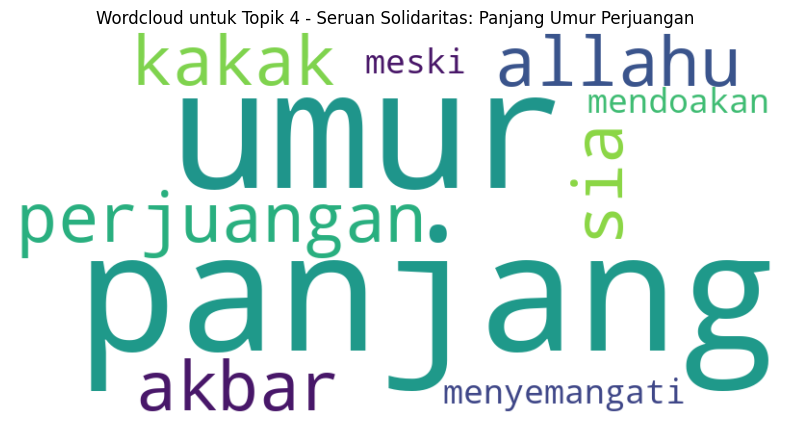

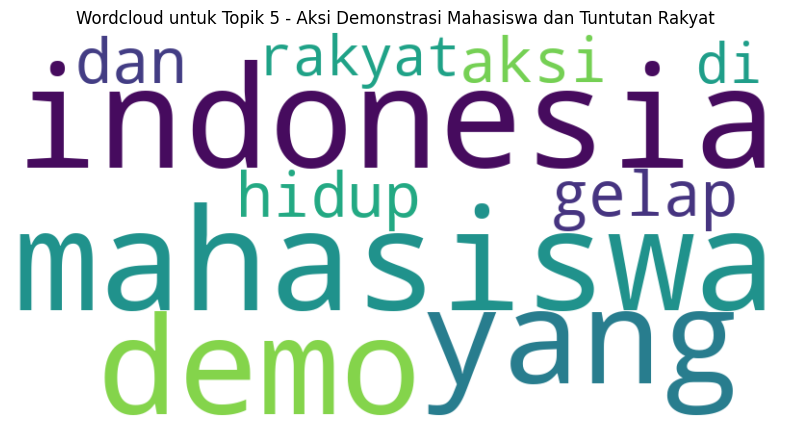

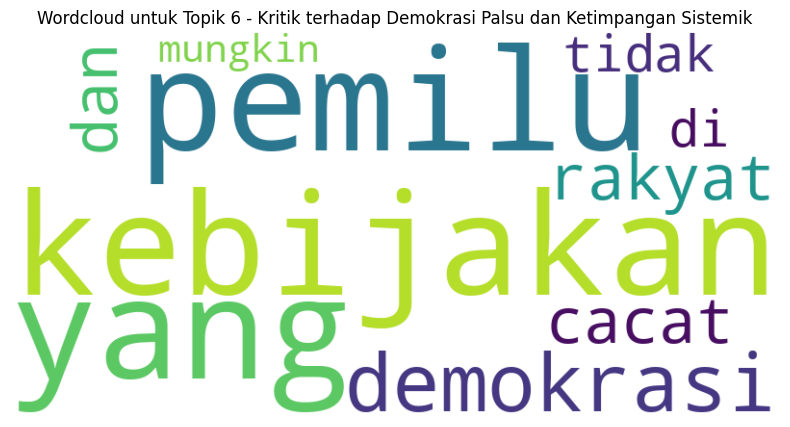

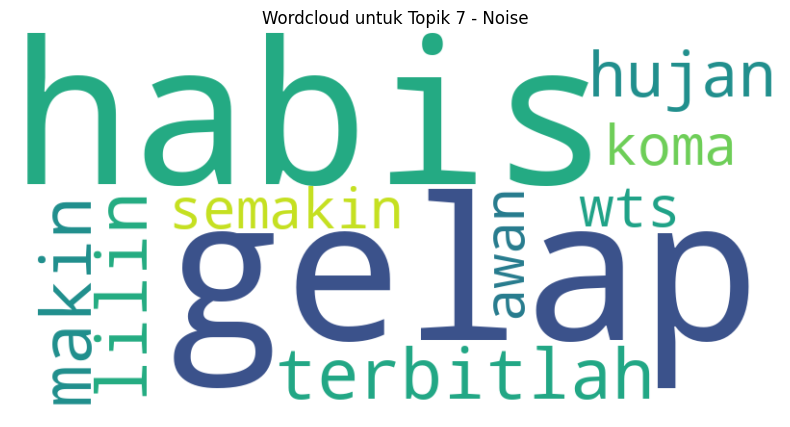

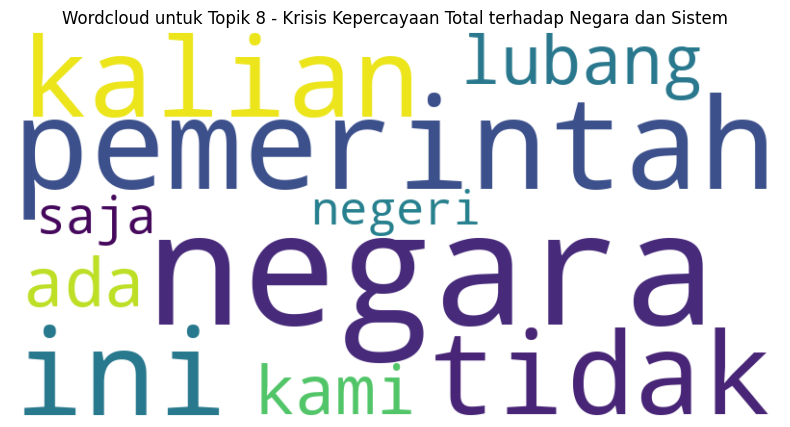

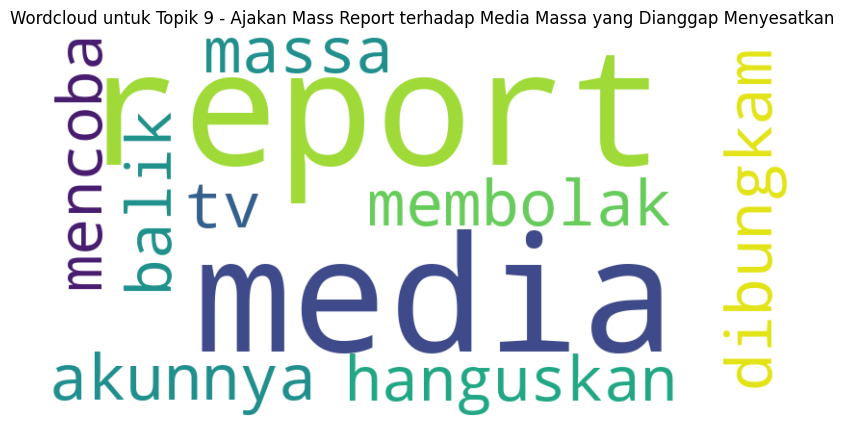

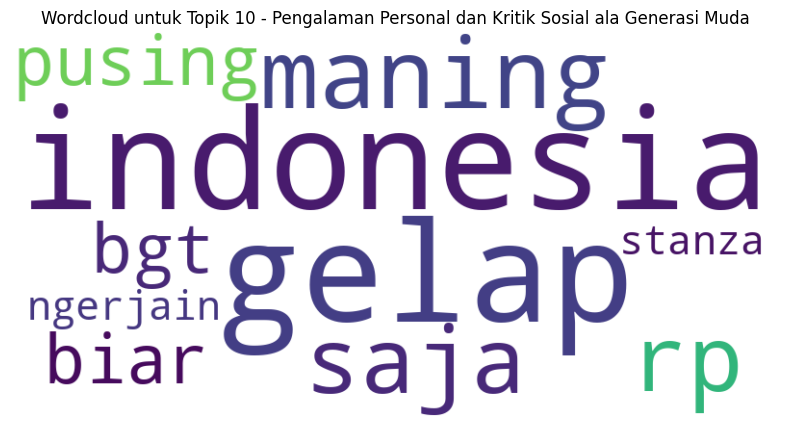

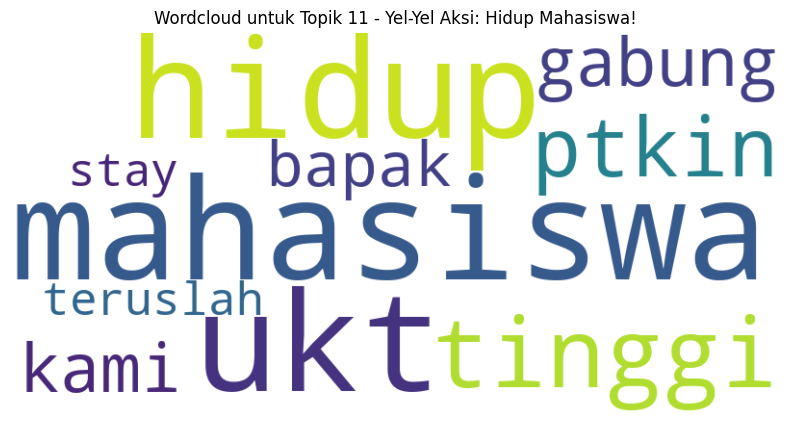

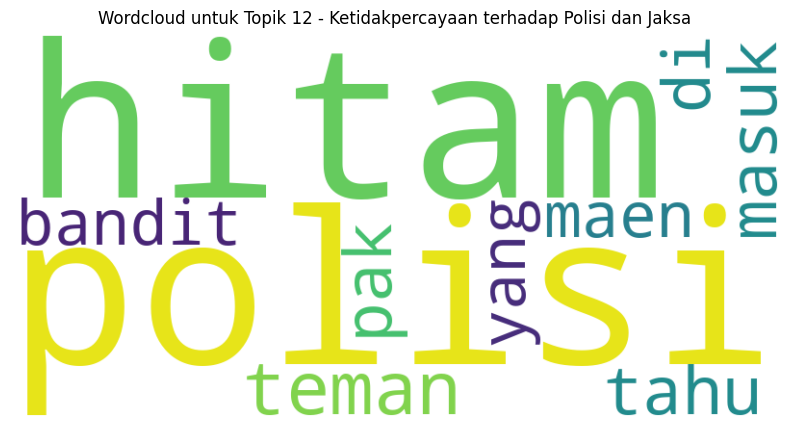

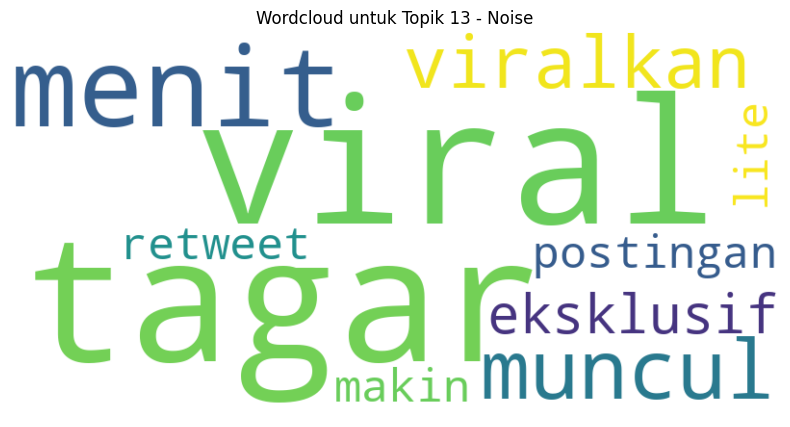

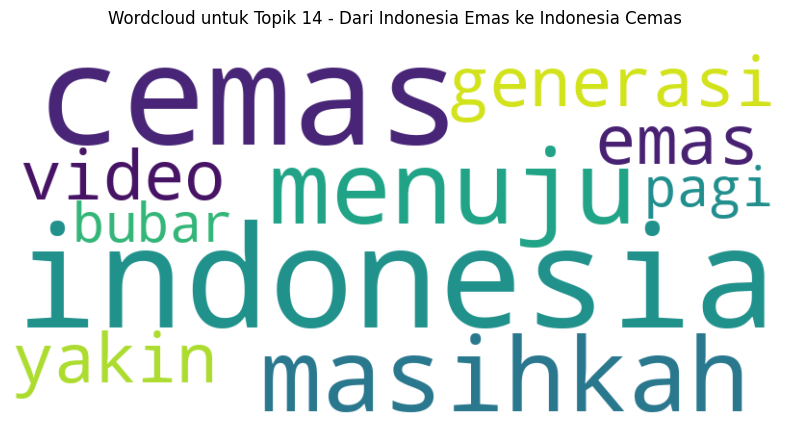

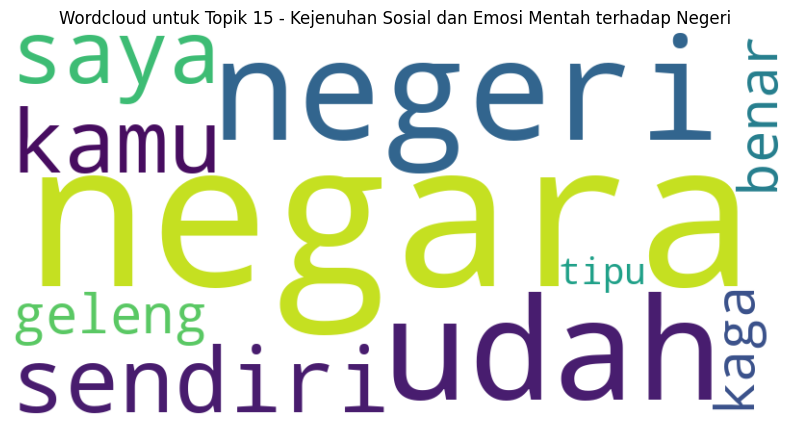

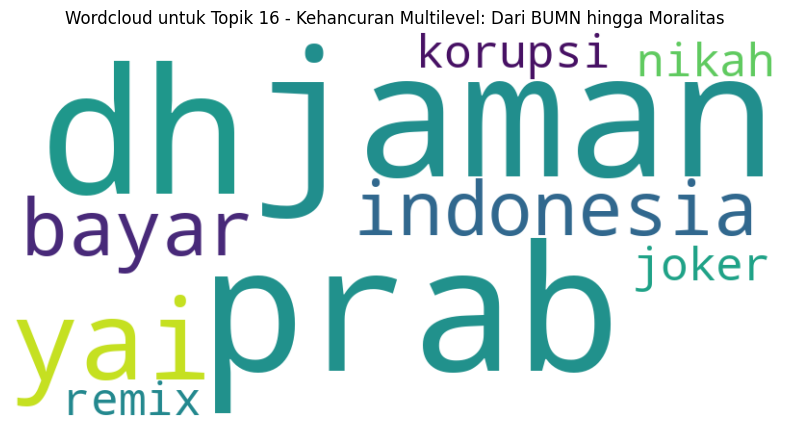

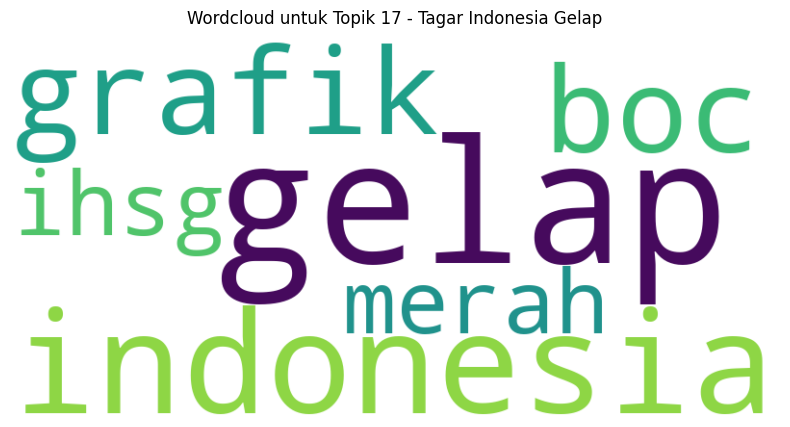

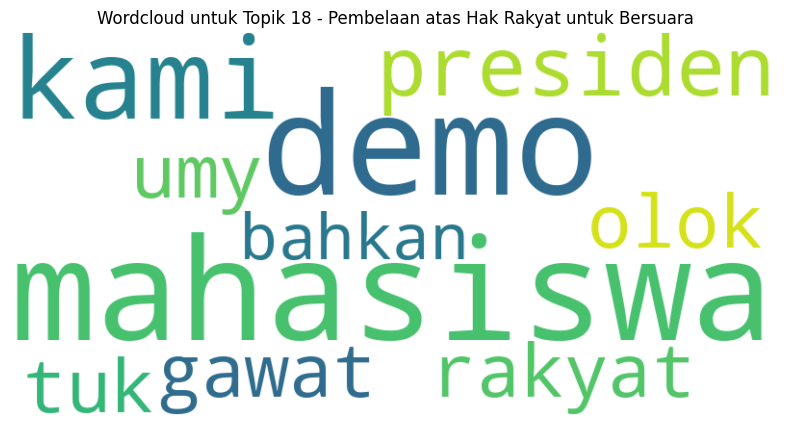

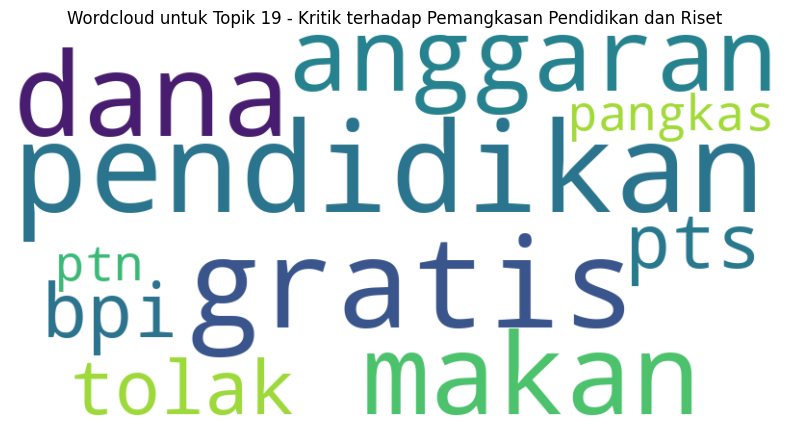

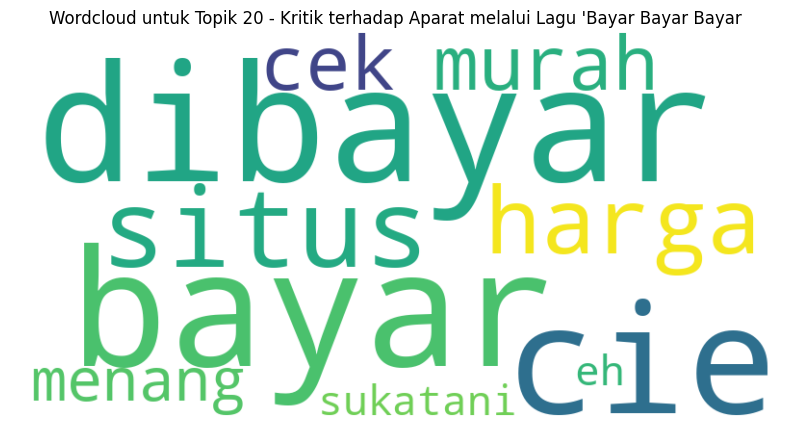

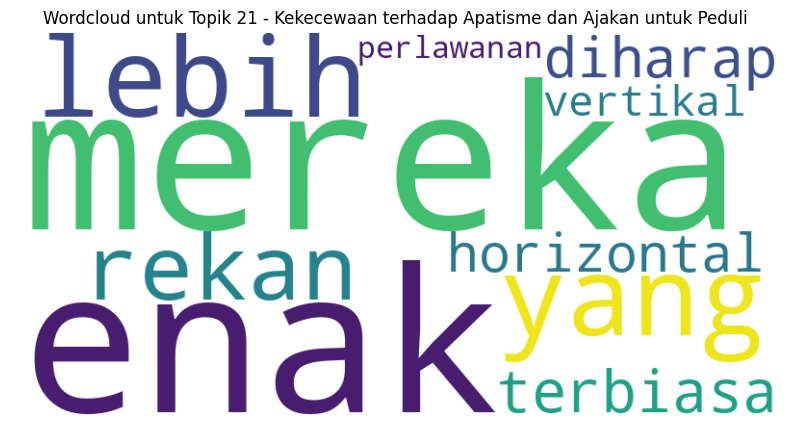

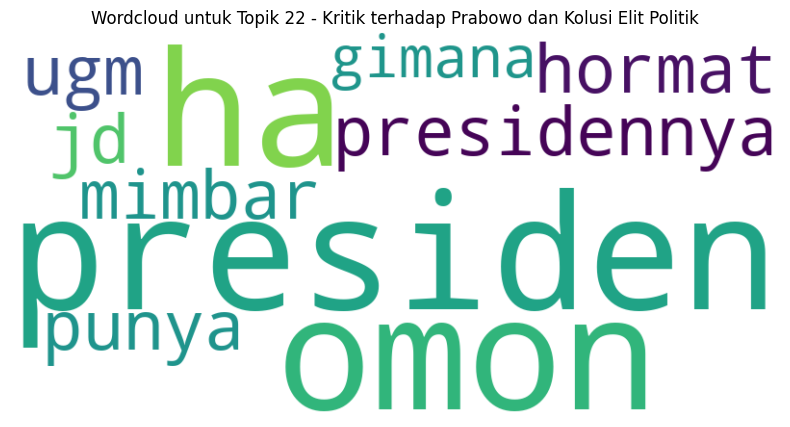

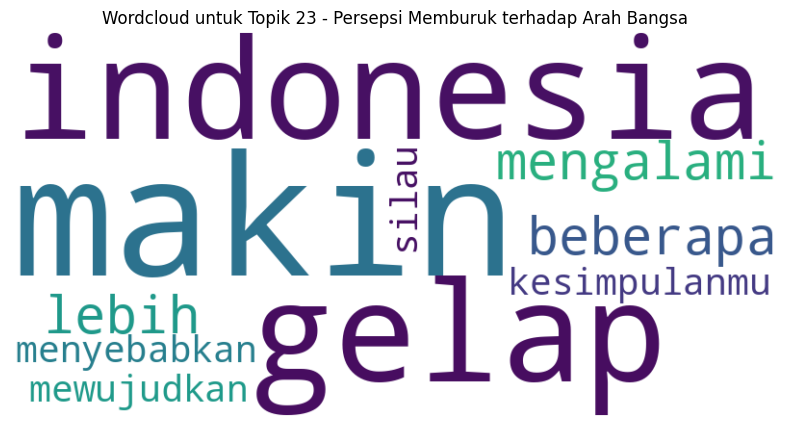

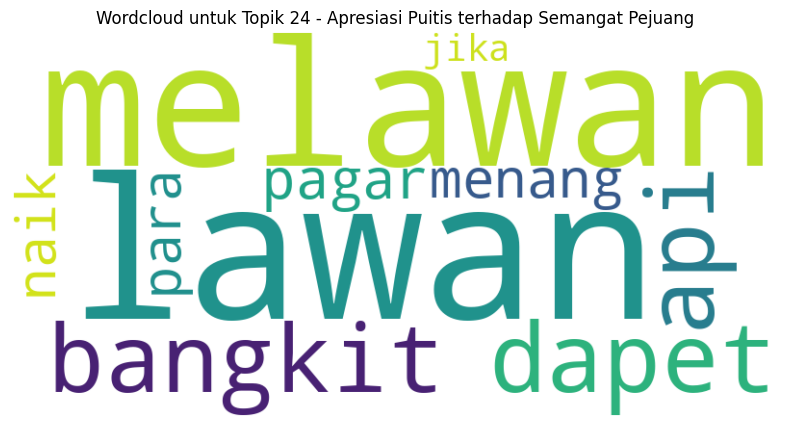

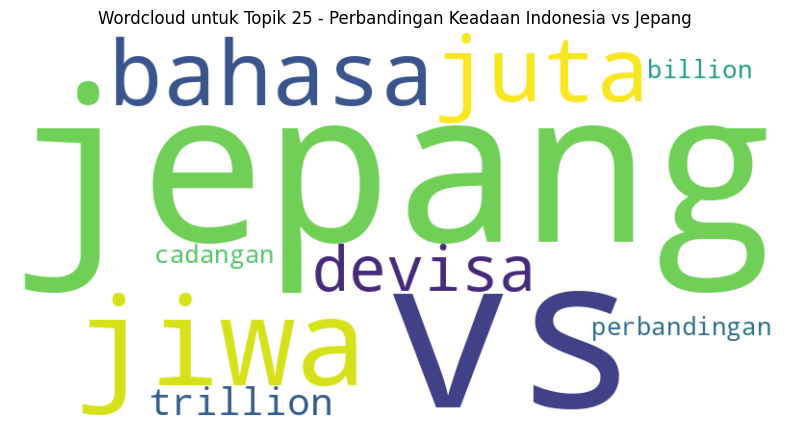

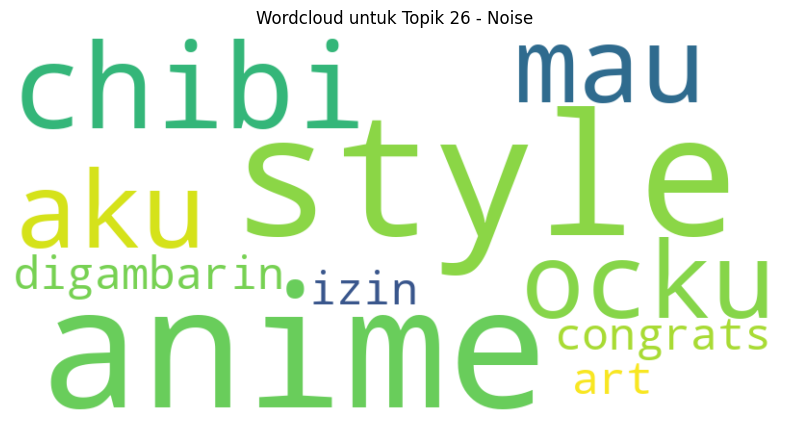

In [37]:
from wordcloud import WordCloud

for topic_id in tm["Topic"]:  # contoh 5 topik awal
    words = " ".join([w for w, _ in topic_model.get_topic(topic_id)])
    wc = WordCloud(width=800, height=400, background_color='white').generate(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud untuk Topik {topic_id} - {tm.loc[tm.Topic==topic_id, 'Custom_Label'].values[0]}")
    plt.show()

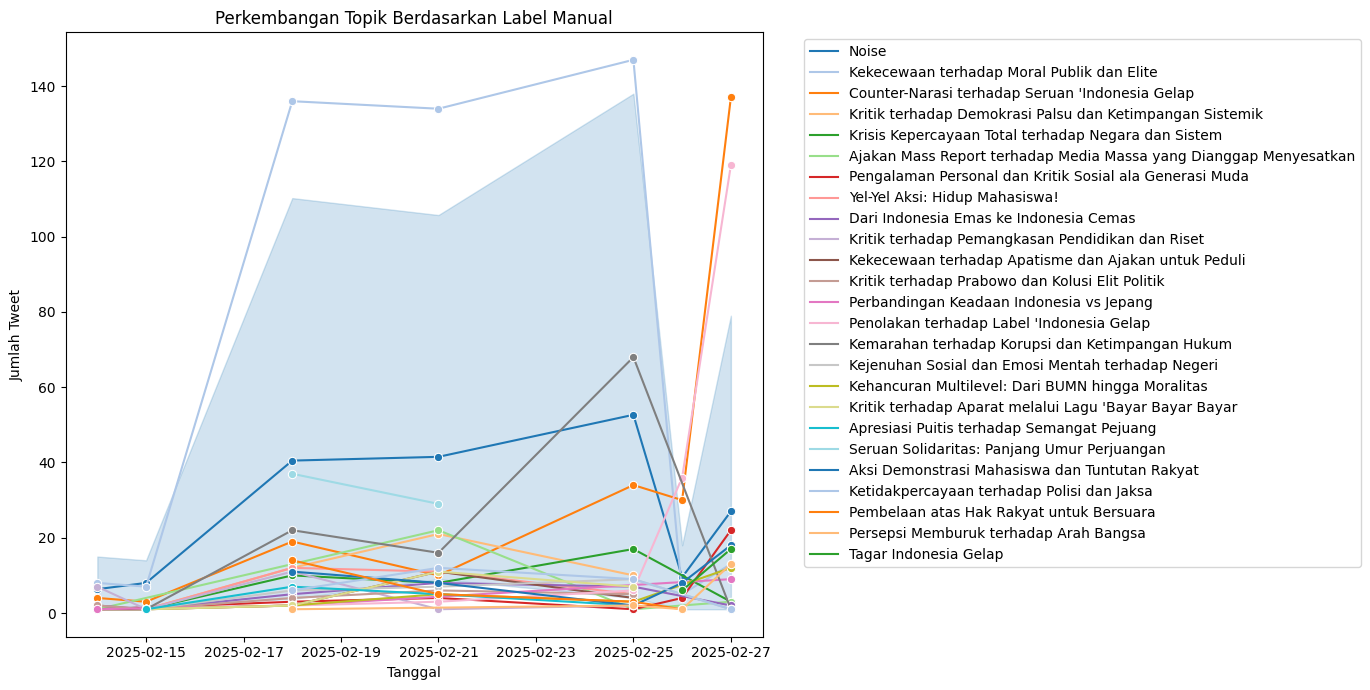

In [40]:
topics_over_time = topic_model.topics_over_time(tweets, timestamps=df_prepro["date"])

# Buat mapping dari topic ID ke Custom_Label
topic_label_map = dict(zip(tm['Topic'], tm['Custom_Label']))

# Tambahkan kolom label manual ke hasil topics_over_time
topics_over_time['Custom_Label'] = topics_over_time['Topic'].map(topic_label_map)

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=topics_over_time,
    x='Timestamp', y='Frequency',
    hue='Custom_Label', marker='o', palette='tab20'
)
plt.title("Perkembangan Topik Berdasarkan Label Manual")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Tweet")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
